### References:

Original HHL:
https://arxiv.org/pdf/0811.3171.pdf

Quantum Circuit Design for Solving Linear Systems of Equations:
https://arxiv.org/pdf/1110.2232v2.pdf

Step-by-Step HHL:
https://arxiv.org/abs/2108.09004

Qiskit:
https://qiskit.org/learn/

In [1]:
# Import Qiskit libraries
from qiskit import *
from qiskit.quantum_info.operators import Operator
from qiskit.extensions import *
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import SwapGate, RYGate, QFT

# Importing numpy libraries for classical solutions
import numpy as np
from numpy import linalg as LA

from copy import deepcopy

Hermitian Matrix Definition

In [2]:
# Function that checks if matrix is Hermitian

def check_hermitian(mat):
    # If matrix = transposed, conjugate matrix 
    if np.allclose(mat, mat.T.conjugate(), rtol=1e-05, atol=1e-08):
        print("Matrix is hermitian.")
    else:
        print("The inputted matrix is not Hermitian.")

Problem to solve

$$ A\vec{x} = \vec{b} $$

Sample 4x4 matrix is 

$$ A = \frac{1}{4} \begin{pmatrix}
15 & 9  & 5 & -3\\
9  & 15 & 3 & -5\\
5  & 3  & 15 & -9 \\
-3 & -5 &-9 & 15
\end{pmatrix} $$

with 

$$ \vec{b} = \frac{1}{2} \begin{pmatrix}
1 & 1  & 1 & 1\\
\end{pmatrix}^T$$

Below, is where the initial matrix to be solved will be defined. Included are sample matrices that were used when trying to follow examples in papers/ones we created. 

In [3]:
# Define linear system (Works with 2x2 or 4x4 Matrix)

# Sample 4x4 Matrix
# A = 0.25*np.array([[15.,9,5,-3],[9,15,3,-5],[5.,3,15,-9],[-3.,-5,-9,15]])
# b = 0.5*np.array([1,1,1,1,1,1,1,1]).T

# Matrix from Example Paper
#A = np.array([[0, 1, 1, 0], [1, -1, 0, 0], [1, 0, -.5, 0], [0,0,0,1]])
#b = np.array([0, 0, -.5, 0])

# Sample 4x4 Matrix 
# A = np.array([[1,2,0,0],[2,1,0,0],[0,0,1,2],[0,0,2,1]])
# b = np.array([1,1,1,1]).T

# Sample 2x2 Matrix (We defined)
A = np.array([[1, 4], [4, 1]])
b = np.array([2, 3])

# Normalizing vector b
norm_b = LA.norm(b)
A = A / norm_b
b = b / norm_b

# Exact solution 
csol = LA.solve(A,b)

# Calling previously defined function that checks if function is Hermitian
check_hermitian(A) 

Matrix is hermitian.


Parameters set up for running algorithm. 

In [4]:
# Parameters
c_num = 8 # Number of Qubits
b_num = int(np.log2(len(b)))

t = 2*np.pi               # Hamiltonain parameter
r = 5                     # Rotation parameter

shots = 100000            # Total number of times circuit is run

Use diagram of HHL here and compare each code block to each step of HHL algorithm (include math when possible)

### State Preperation
Given the number of qubits defined, the state can be initaizlied. The total number of qubits will be n$_b$ + n + 1. n$_b$ are the number of bits needed for the b register, n are the number of bits required for the clocking bit, the 1 comes from the LSB.

The bits will be initalized as 
 
$$ | \Psi_{0} \rangle =  | 0 \cdot \cdot \cdot 0 \rangle_b \:| 0 \cdot \cdot \cdot 0 \rangle_c \:|0  \rangle_a$$

In [5]:
# Creating HHL Quantum Circuit

def run_quantum_circuit(r,t):
    # Qubits
    ancilla_qbit = QuantumRegister(1,'ancilla')
    c_qreg = QuantumRegister(c_num,name='regC')
    b_qreg = QuantumRegister(b_num,name='regb')
    
    # Classical bits
    ancilla_cbit = ClassicalRegister(1,name='ancilla\_c')
    b_creg = ClassicalRegister(b_num,name='regb\_c')

    # Create an empty circuit
    circ = QuantumCircuit(ancilla_qbit, c_qreg, b_qreg, ancilla_cbit, b_creg)


    # Intitialize state b (Refer to State Preparation state)
    init = Initialize(list(b))
    circ.append(init,b_qreg)
    circ.draw()

    # Apply Hadamard on register C
    circ.h(c_qreg)

    # Apply controlled-Hamiltonian operators on register b
    for i in range(c_num):
        time = t/(2**(c_num-i))
        U = HamiltonianGate(A, time)
        G = U.control(1)
        qubit = [i+1]+[c_num+j+1 for j in range(b_num)]
        circ.append(G,qubit)

    # Apply inverse quantum Fourier Transform
    iqft = QFT(c_num,approximation_degree=0, do_swaps=True, inverse=True,name='IQFT')
    circ.append(iqft,c_qreg)

    # Swap the qubits in register C
    G = SwapGate()
    circ.append(G,[c_qreg[1],c_qreg[c_num-1]])

    # Apply y rotations on Ancilla qubit
    for i in range(c_num):
        theta = (2**(c_num - r - i)) *np.pi
        U = RYGate(theta).control(1)
        circ.append(U,[i+1,0])

    # ================ Uncompute the circuit ================

    # Swap the qubits in register C
    G = SwapGate()
    circ.append(G,[c_qreg[1],c_qreg[c_num-1]])

    # Apply quantum Fourier Transform
    qft = QFT(c_num,approximation_degree=0, do_swaps=True, inverse=False, name='QFT')
    circ.append(qft,c_qreg)


    # Apply inverse controlled-Hamiltonian operators on register b
    for i in range(c_num-1,-1,-1):
        time = t/(2**(c_num-i))
        U = HamiltonianGate(-A, time)
        G = U.control(1)
        qubit = [i+1]+[c_num+j+1 for j in range(b_num)]
        circ.append(G,qubit)


    # Apply Hadamard on register C
    circ.h(c_qreg)

    # Measure the qubits
    circ.measure(ancilla_qbit,ancilla_cbit)
    circ.measure(b_qreg,b_creg)

    # Run on local simulator
    backend = Aer.get_backend("qasm_simulator")

    simulate = execute(circ, backend=backend, shots=shots)
    results = simulate.result()

    return (results.get_counts(), circ)
  

In [6]:
# Extract approximate solution of the quantum linear solver
def approximate_quantum_sol(sol,b_num):
    num = 0
    app_sol = np.zeros(2**(b_num))

    for key, value in sol.items(): 
        if key[-1] == '1':
            num += value 
            cord = int(key[:b_num],base=2)
            app_sol[cord] = value
  
    app_sol = 1/num *app_sol
    return app_sol

============================== Final results ==============================

Exact solution =  [0.66666667 0.33333333]
Quantum solver solution =  [0.65299685 0.34700315]
Norm of difference =  0.019332046593954096 



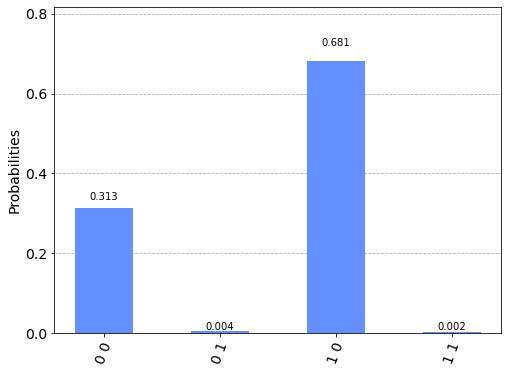

In [7]:
# Final results
result, circ = run_quantum_circuit(r = 6, t = 3*np.pi)
# Solution from HHL
qsol = approximate_quantum_sol(result,b_num)

print("============================== Final results ==============================\n")
print ('Exact solution = ', csol)
print('Quantum solver solution = ', qsol)
print('Norm of difference = ', LA.norm(qsol- csol),'\n')

plot_histogram(result,figsize = (8,6),bar_labels = True)

============================== Circuit structure ============================== 



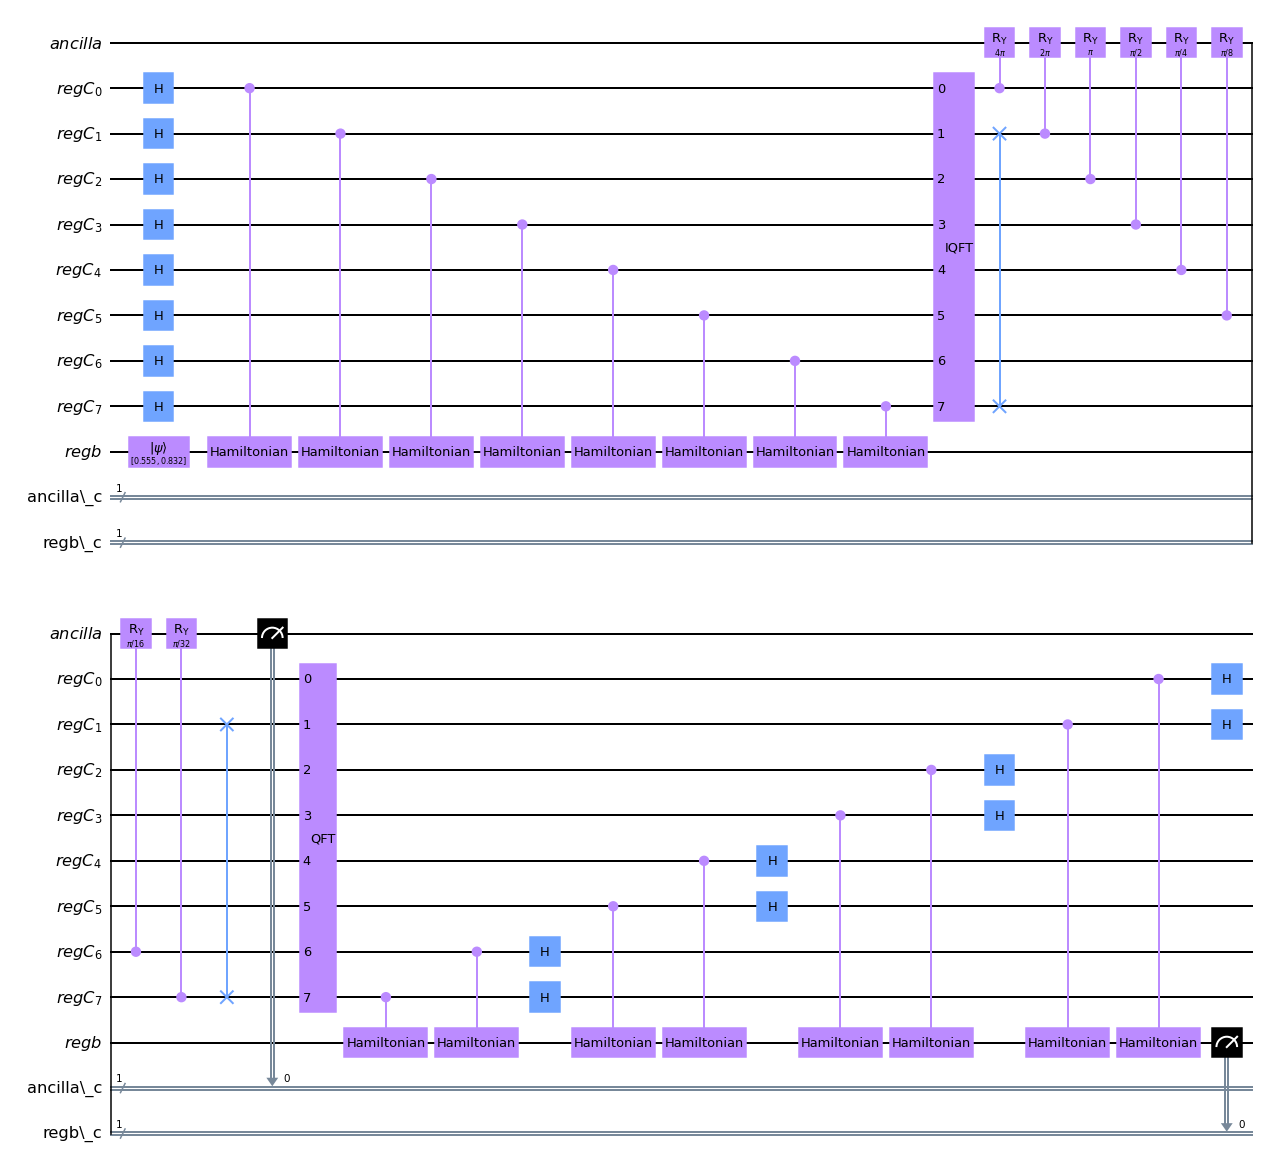

In [8]:
# Draw the quantum circuit
print("============================== Circuit structure ============================== \n")
circ.draw(output='mpl')